### Loading data

In [122]:
import pandas as pd 
import numpy as np
import requests 
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import pgeocode
import geocoder

In [123]:
# Load Prague data and delete duplicate postal codes
req = requests.get('https://www.mapa-prahy.com/psc-praha') 
soup = BeautifulSoup(req.content,'lxml') 
table = soup.find_all('table')[0]
df_Prg = pd.read_html(str(table))[0]
df_Prg.columns = ['Name', 'Postal_code', 'Post']
df_Prg.drop_duplicates(subset ="Postal_code", keep = 'first' , inplace = True)
df_Prg['City'] = 'Prague'
print(df_Prg.Postal_code.unique().shape)
print(df_Prg.shape)
df_Prg.head(5)

(60,)
(60, 4)


,Name,Postal_code,Post,City
0,Běchovice,19011,Praha 911,Prague
1,Benice,10300,Praha 113,Prague
2,Bohnice (část),18100,Praha 81,Prague
3,Bohnice (část),18200,Praha 82,Prague
4,Braník (část),14000,Praha 4,Prague


In [124]:
# Load Brno data and delete duplicate postal codes
req = requests.get('https://www.smerovak.cz/psc-kraj-jihomoravsky-Brno_m%C4%9Bsto') 
soup = BeautifulSoup(req.content,'lxml') 
table = soup.find_all('table')[0]
df_Brno = pd.read_html(str(table))[0]
df_Brno.columns =['Postal_code', 'Post', 'City', 'Name']
df_Brno = df_Brno[1:][['Name', 'Postal_code', 'Post', 'City']]
df_Brno.drop_duplicates(subset ="Postal_code", keep = 'first' , inplace = True)
print(df_Brno.Postal_code.unique().shape)
print(df_Brno.shape)
df_Brno.head(5)

(31,)
(31, 4)


,Name,Postal_code,Post,City
1,Bohunice,61900,Brno 19,Brno
2,Bohunice,62500,Brno 25,Brno
3,Bohunice,63900,Brno 39,Brno
4,Bosonohy,64200,Brno 42,Brno
5,Brněnské Ivanovice,61700,Brno 17,Brno


In [125]:
df_cities = pd.concat([df_Brno, df_Prg],ignore_index=True)
df_cities.shape

(91, 4)

### Getting coordinates

In [126]:
# Postal code as string and empty columns
df_cities.Postal_code = df_cities.Postal_code.astype(str)
df_cities['latitude'] = np.nan
df_cities['longitude'] = np.nan
df_cities['place_name'] = np.nan
df_cities['PSC'] = np.nan

In [127]:
# Getting geo coordinates
nomi = pgeocode.Nominatim('CZ')
for j in range(df_cities.shape[0]):
    PSC = df_cities.Postal_code[j][0:3] + ' ' + df_cities.Postal_code[j][3:5]
    infos = nomi.query_postal_code(PSC)
    df_cities['PSC'][j] = PSC
    df_cities['latitude'][j] = infos['latitude']
    df_cities['longitude'][j] = infos['longitude']
    df_cities['place_name'][j] = infos['place_name']

<ipython-input-127-bf4c935085a9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cities['PSC'][j] = PSC
C:\Users\PetrHanzlik\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-127-bf4c935085a9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cities['latitude'][j] = infos['latitude']
<

In [128]:
# Delete not found values
df_cities = df_cities[df_cities['longitude'].isnull() == False]
df_cities = df_cities[df_cities['latitude'].isnull() == False]

In [129]:
df_cities[df_cities['City'] == 'Brno'].shape

(30, 8)

### Alternatively - brought worse results

In [130]:
'''
latlong = pd.read_csv('CZ_latlong.csv')

df_Prg = latlong[latlong['Postal'].str[0] == '1']

df_Brno = latlong[latlong['Postal'].str[0] == '6']
df_Brno = df_Brno[df_Brno['Name'].str.contains("Brno")]
df_cities = pd.concat([df_Brno, df_Prg],ignore_index=True)
df_cities.drop_duplicates(subset ="Postal", keep = 'first' , inplace = True)
df_cities.columns = ['Country', 'Postal_code', 'Name', 'Region', 'latitude', 'longitude','latitude_alt', 'longitude_alt']
df_cities
'''

'\nlatlong = pd.read_csv(\'CZ_latlong.csv\')\n\ndf_Prg = latlong[latlong[\'Postal\'].str[0] == \'1\']\n\ndf_Brno = latlong[latlong[\'Postal\'].str[0] == \'6\']\ndf_Brno = df_Brno[df_Brno[\'Name\'].str.contains("Brno")]\ndf_cities = pd.concat([df_Brno, df_Prg],ignore_index=True)\ndf_cities.drop_duplicates(subset ="Postal", keep = \'first\' , inplace = True)\ndf_cities.columns = [\'Country\', \'Postal_code\', \'Name\', \'Region\', \'latitude\', \'longitude\',\'latitude_alt\', \'longitude_alt\']\ndf_cities\n'

### Initial visualization

In [131]:
mapTor = folium.Map(location=[49.684508, 15.297493], zoom_start=8)
for lat, lng, neighborhood, postal_code in zip(df_cities['latitude'], df_cities['longitude'], df_cities['Name'], df_cities['Postal_code']):
    label = '{}, {}'.format(neighborhood, postal_code)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mapTor)  
    
mapTor

As we can see, locating postal codes did not work perfectly. Worse results were obtained from imported file. In order to have better data quality, too far off poitns were deleted and new random points were added to Brno which has almost no points in the center.

In [132]:
# Adding actual data in Brno
df_cities = df_cities.append({'Postal_code': 'Made up',
'Name': 'Uvoz',
'City': 'Brno',
'latitude': 49.195203,
'longitude': 16.59164}, ignore_index = True)

df_cities = df_cities.append({'Postal_code': 'Made up',
'Name': 'Zebetin',
'City': 'Brno',
'latitude': 49.207354,
'longitude': 16.486927}, ignore_index = True)

df_cities = df_cities.append({'Postal_code': 'Made up',
'Name': 'Ustredni hrbitov',
'City': 'Brno',
'latitude': 49.167123,
'longitude': 16.599279}, ignore_index = True)

df_cities = df_cities.append({'Postal_code': 'Made up',
'City': 'Brno',
'Name': 'Lisen',
'latitude': 49.207195,
'longitude': 16.694551}, ignore_index = True)

df_cities = df_cities.append({'Postal_code': 'Made up',
'Name': 'Veterina',
'City': 'Brno',
'latitude': 49.217521,
'longitude': 16.600738}, ignore_index = True)

df_cities = df_cities.append({'Postal_code': 'Made up',
'Name': 'Bystrc',
'City': 'Brno',
'latitude': 49.226388 ,
'longitude': 16.529584}, ignore_index = True)

df_cities = df_cities.append({'Postal_code': 'Made up',
'Name': 'Koliste',
'City': 'Brno',
'latitude': 49.194661 ,
'longitude': 16.616188}, ignore_index = True)


# Deleting data too far off
df_cities = df_cities[df_cities.Postal_code.isin(['15600', '62700', '60300', '61600', '62500', '61700', '19700', '61800', '10700', '15300', '63800', '61300', '18600', '62800', '11900', '11000', '62800', '14800', '60200', '11800', '61500', '61200', '63400', '18000', '14900', '14300']) == False]

df_cities

,Name,Postal_code,Post,City,latitude,longitude,place_name,PSC
0,Bohunice,61900,Brno 19,Brno,49.166700,16.622217,"Horní Heršpice, Přízřenice, Dolní Heršpice, Br...",619 00
2,Bohunice,63900,Brno 39,Brno,49.141700,16.366700,"Štýřice, Brno-Štýřice",639 00
3,Bosonohy,64200,Brno 42,Brno,49.166700,16.533300,"Bosonohy, Brno-Bosonohy",642 00
5,Brněnské Ivanovice,62000,Brno 20,Brno,49.150000,16.670825,"Brněnské Ivanovice, Dvorska, Tuřany, Holásky, ...",620 00
6,Brno-Bystrc,63500,Brno 35,Brno,49.233300,16.525000,"Brno-Kníničky, Kníničky, Bystrc, Brno-Bystrc",635 00
...,...,...,...,...,...,...,...,...
92,Ustredni hrbitov,Made up,NaN,Brno,49.167123,16.599279,NaN,NaN
93,Lisen,Made up,NaN,Brno,49.207195,16.694551,NaN,NaN
94,Veterina,Made up,NaN,Brno,49.217521,16.600738,NaN,NaN
95,Bystrc,Made up,NaN,Brno,49.226388,16.529584,NaN,NaN


### Getting Foursquare venues

In [133]:
cred = pd.read_csv('Foursquare_credentials.csv')
CLIENT_ID = cred.Value[0]
CLIENT_SECRET = cred.Value[1]
VERSION = '20180605'
LIMIT = 20

In [134]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Name', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [135]:
CZ_venues = getNearbyVenues(names=df_cities['Name'],
                                   latitudes=df_cities['latitude'],
                                   longitudes=df_cities['longitude']
                                  )

Bohunice
Bohunice
Bosonohy
Brněnské Ivanovice
Brno-Bystrc
Brno-Bystrc
Brno-Chrlice
Brno-Chrlice
Brno-Husovice
Brno-Ivanovice
Brno-Kníničky
Brno-Kohoutovice
Brno-Komín
Brno-Líšeň
Brno-Obřany
Brno-Pisárky
Brno-Žebětín
Běchovice
Benice
Bohnice (část)
Bohnice (část)
Braník (část)
Braník (část)
Braník (část)
Břevnov (Praha 6) (část)
Břevnov (Praha 6) (část)
Bubeneč (Praha 6)
Bubeneč (Praha 7)
Chodov (část)
Čakovice
Černý Most
Čimice (část)
Dejvice (část)
Dolní Měcholupy (Praha-Dolní Měcholupy)
Dolní Měcholupy (Praha-Dubeč) (část)
Dolní Počernice
Dubeč (část)
Hájek
Hloubětín (Praha 9) (část)
Hlubočepy (část)
Hlubočepy (část)
Hlubočepy (část)
Horní Počernice (část)
Jinonice (Praha 13)
Jinonice (Praha 5) (část)
Klánovice
Koloděje
Lahovice
Letňany (část)
Liboc (část)
Lipence (část)
Lipence (část)
Lysolaje
Malešice (Praha 10) (část)
Malešice (Praha 10) (část)
Nové Město (Praha 2) (část)
Nové Město (Praha 2) (část)
Radotín (část)
Řepy (část)
Satalice
Sobín
Strašnice (Praha 10) (část)
Troja (Praha

In [136]:
print(CZ_venues.shape)
print('There are {} uniques categories.'.format(len(CZ_venues['Venue Category'].unique())))
CZ_venues.head()

(585, 7)
There are 165 uniques categories.


,Name,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bohunice,49.1667,16.622217,Koupaliště biotop Brno-jih,49.169542,16.620332,Pool
1,Bohunice,49.1667,16.622217,Lezecké centrum Komec,49.169820,16.623634,Climbing Gym
2,Bohunice,49.1667,16.622217,Komec,49.169827,16.623684,Athletics & Sports
3,Bohunice,49.1667,16.622217,Kšírovka,49.169021,16.618907,Golf Course
4,Bohunice,49.1667,16.622217,Městský baseballový stadión,49.167488,16.624050,Baseball Stadium


In [137]:
# Adjust encoding

onehot = pd.get_dummies(CZ_venues[['Venue Category']], prefix="", prefix_sep="")
onehot['Name'] = CZ_venues['Name'] 

fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

grouped = onehot.groupby('Name').mean().reset_index()
grouped.head()

,Name,ATM,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,...,Vegetarian / Vegan Restaurant,Vehicle Inspection Station,Vietnamese Restaurant,Vineyard,Volleyball Court,Whisky Bar,Wine Bar,Yoga Studio,Zoo,Zoo Exhibit
0,Benice,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,Bohnice (část),0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,Bohunice,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,Bosonohy,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,Braník (část),0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0


In [138]:
# Set amount of clusters and venues
num_top_venues = 15
kclusters = 7

In [139]:
# Descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

indicators = ['st', 'nd', 'rd']

columns = ['Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Name'] = grouped['Name']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue
0,Benice,Trail,Train Station,Restaurant,Athletics & Sports,Bus Stop,Basketball Court,ATM,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Museum,Music Venue,Nature Preserve,Mexican Restaurant
1,Bohnice (část),Bus Stop,Restaurant,Supermarket,Playground,Movie Theater,Hospital,Chinese Restaurant,Park,Soccer Field,Brewery,Café,Shopping Plaza,ATM,Nature Preserve,Museum
2,Bohunice,Food Court,Climbing Gym,Boat or Ferry,Bus Station,Bike Rental / Bike Share,Electronics Store,Baseball Stadium,Golf Course,Baseball Field,Pool,Athletics & Sports,Clothing Store,Pharmacy,Nature Preserve,Movie Theater
3,Bosonohy,Beer Garden,ATM,Nature Preserve,Middle Eastern Restaurant,Monument / Landmark,Motel,Motorcycle Shop,Movie Theater,Museum,Music Venue,Office,Metro Station,Organic Grocery,Outdoor Sculpture,Park
4,Braník (část),Bus Stop,Hotel,Gym / Fitness Center,Soccer Field,Italian Restaurant,Motorcycle Shop,Electronics Store,Dog Run,Czech Restaurant,Pet Store,Resort,Restaurant,Pub,Volleyball Court,Trail


### K-means - creating 7 clusters based on 15 top values

In [140]:
grouped_clustering = grouped.drop('Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 5, 6, 0, 0, 0, 5, 4, 2, 5, 5, 0, 5, 5, 0, 0, 5, 5, 0, 5, 0,
       0, 0, 5, 0, 5, 5, 5, 0, 0, 3, 5, 5, 0, 0, 0, 5, 0, 5, 0, 5, 6, 1,
       5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 5])

In [141]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
merged = df_cities.merge(neighborhoods_venues_sorted, left_on='Name', right_on='Name', how='inner')

### Final visualization and clusted descriptions

In [142]:
# create map
map_clusters = folium.Map(location=[49.684508, 15.297493], zoom_start=8)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['latitude'], merged['longitude'], merged['Name'], merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Describing main features of the clusters

In [143]:
# Cluster descriptions
# choose cluster number from 0 to 6

cluster_number = 5
print('Cluster: ', cluster_number)
print(pd.concat([
        merged.loc[merged['Cluster Labels'] == cluster_number]['1st Most Common Venue'],
        merged.loc[merged['Cluster Labels'] == cluster_number]['2nd Most Common Venue'],
        merged.loc[merged['Cluster Labels'] == cluster_number]['3rd Most Common Venue'],
        merged.loc[merged['Cluster Labels'] == cluster_number]['4th Most Common Venue'],
        merged.loc[merged['Cluster Labels'] == cluster_number]['5th Most Common Venue']]).value_counts().nlargest(7))

#merged.loc[merged['Cluster Labels'] == cluster_number, merged.columns[[1] + list(range(5, merged.shape[1]))]]

cluster_number = 0
print('Cluster: ', cluster_number)
print(pd.concat([
        merged.loc[merged['Cluster Labels'] == cluster_number]['1st Most Common Venue'],
        merged.loc[merged['Cluster Labels'] == cluster_number]['2nd Most Common Venue'],
        merged.loc[merged['Cluster Labels'] == cluster_number]['3rd Most Common Venue'],
        merged.loc[merged['Cluster Labels'] == cluster_number]['4th Most Common Venue'],
        merged.loc[merged['Cluster Labels'] == cluster_number]['5th Most Common Venue']]).value_counts().nlargest(7))

Cluster:  5
Restaurant              11
Café                     6
Gym / Fitness Center     6
Hotel                    5
Scenic Lookout           4
Park                     4
Tram Station             4
dtype: int64
Cluster:  0
Bus Stop        30
Hotel           12
Restaurant       7
Supermarket      7
Pub              6
Soccer Field     5
Playground       4
dtype: int64


### Hierarchical clustering

In [144]:
from sklearn.metrics.pairwise import euclidean_distances
dist_matrix = euclidean_distances( grouped.drop('Name', 1), grouped.drop('Name', 1)) 
print(dist_matrix)

[[0.00000000e+00 4.39962070e-01 4.93150361e-01 ... 5.71428571e-01
  4.61724385e-01 4.57675781e-01]
 [4.39962070e-01 7.45058060e-09 4.62090077e-01 ... 4.12233088e-01
  2.73774536e-01 4.18072421e-01]
 [4.93150361e-01 4.62090077e-01 9.12506037e-09 ... 5.90456989e-01
  4.36773797e-01 4.08248290e-01]
 ...
 [5.71428571e-01 4.12233088e-01 5.90456989e-01 ... 0.00000000e+00
  4.06142747e-01 6.02103267e-01]
 [4.61724385e-01 2.73774536e-01 4.36773797e-01 ... 4.06142747e-01
  0.00000000e+00 3.79544698e-01]
 [4.57675781e-01 4.18072421e-01 4.08248290e-01 ... 6.02103267e-01
  3.79544698e-01 7.45058060e-09]]


In [145]:
from scipy.cluster import hierarchy 
Z_using_dist_matrix = hierarchy.linkage(dist_matrix, 'ward')

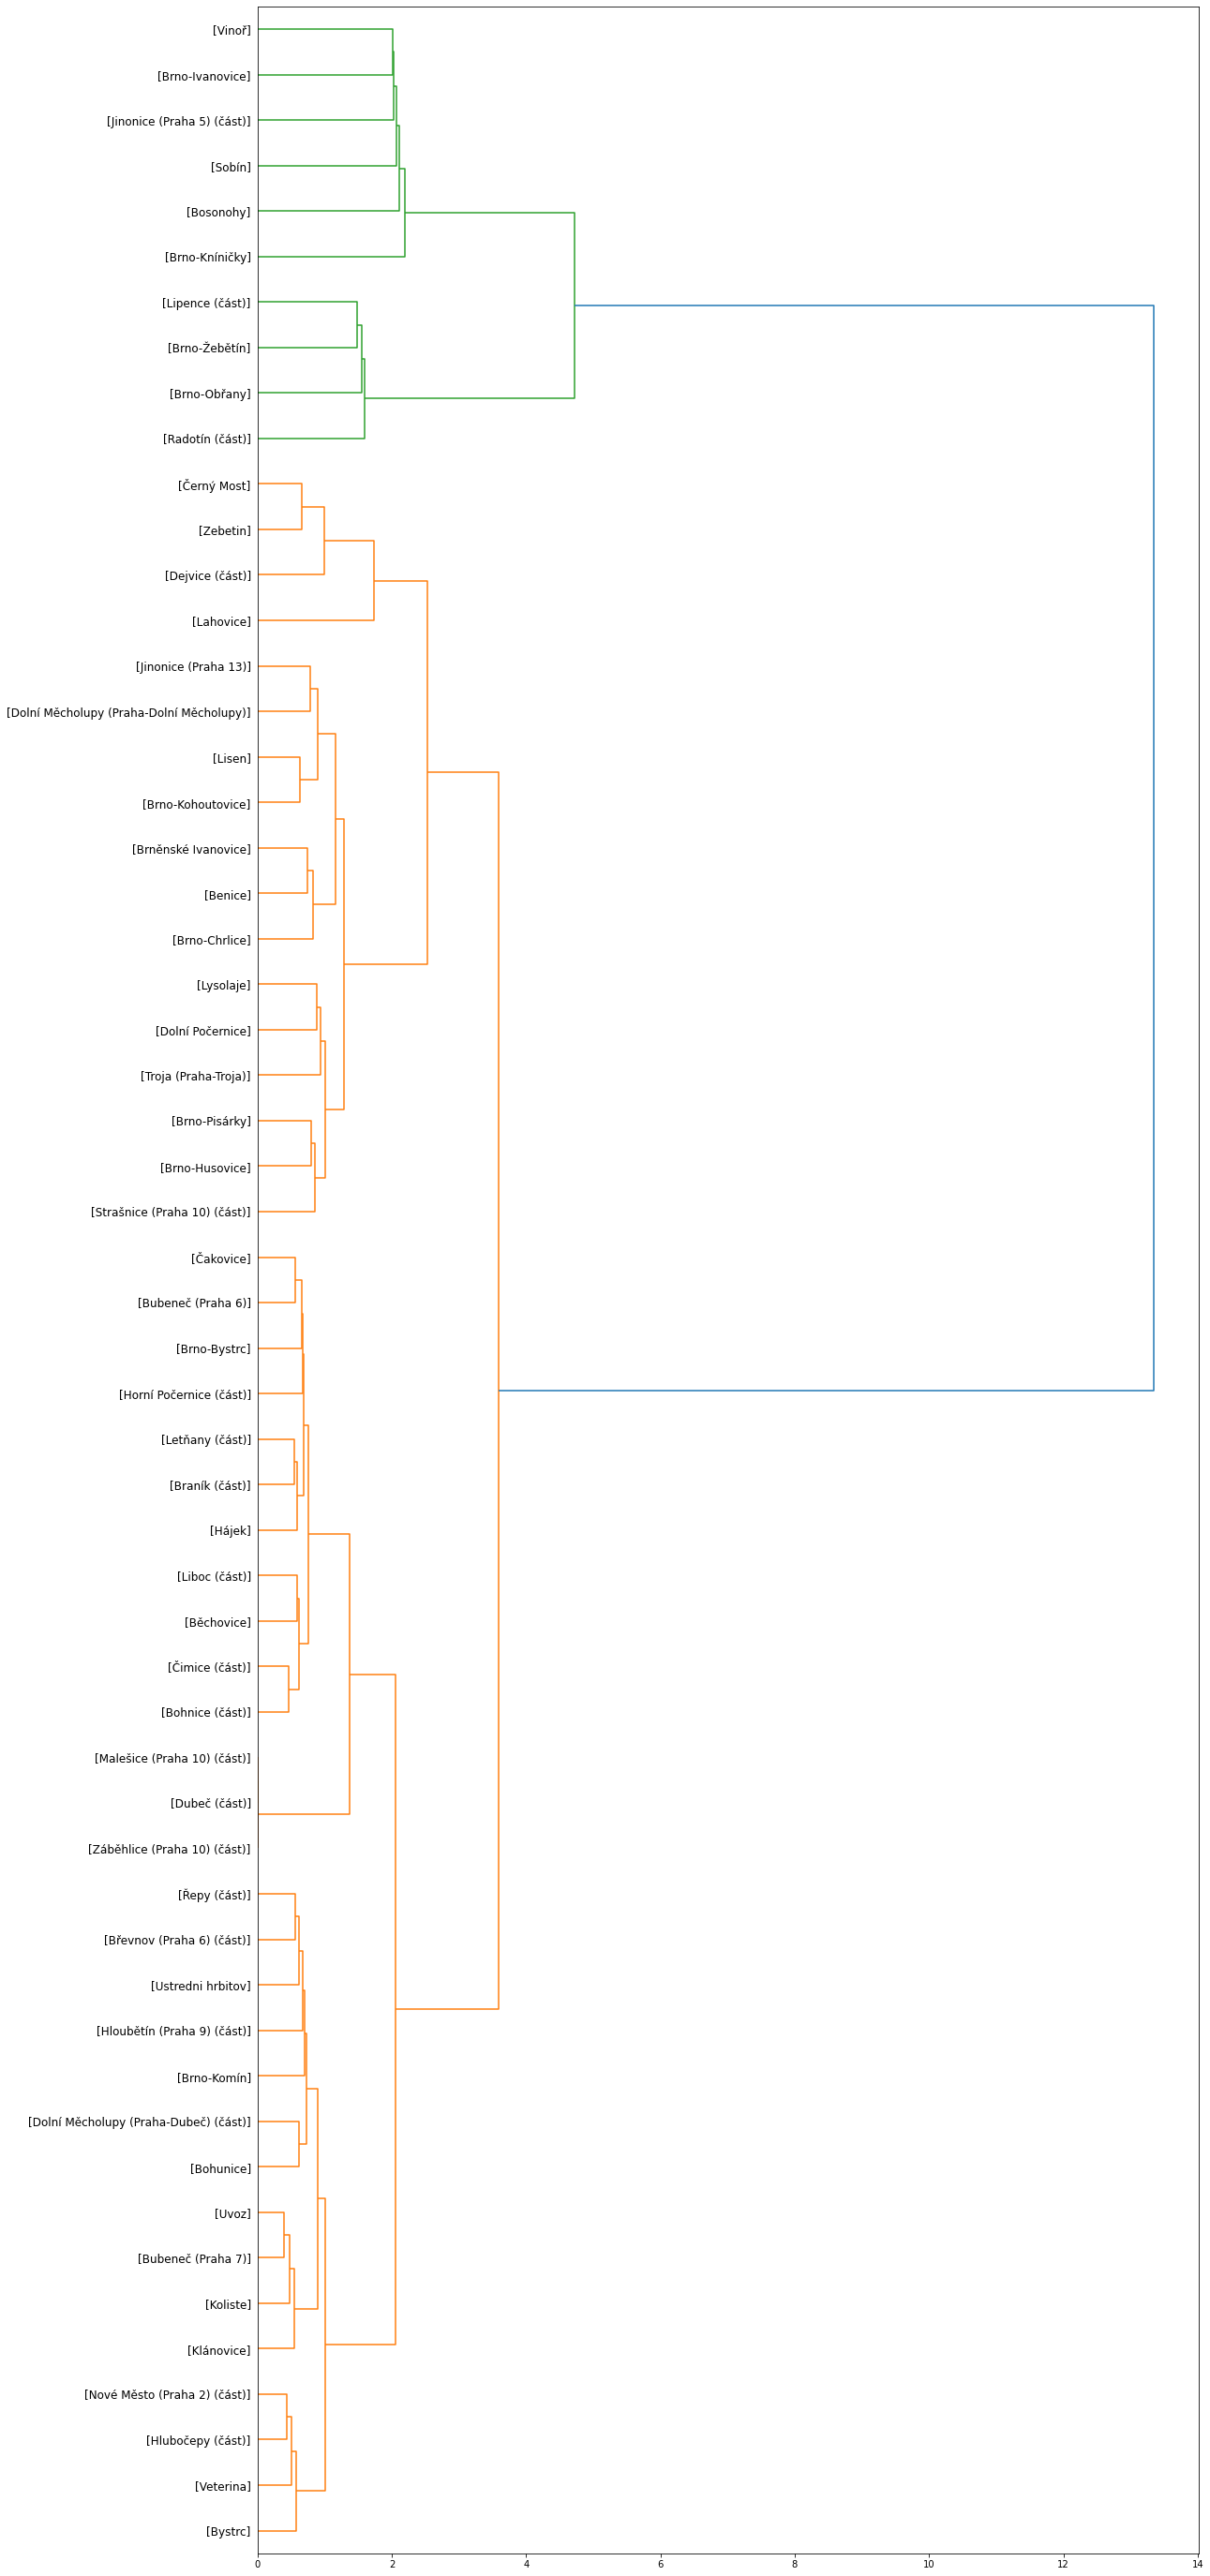

In [146]:
import pylab
fig = pylab.figure(figsize=(18,50))
def llf(id):
    return '[%s]' % (grouped['Name'][id] )
    
dendro = hierarchy.dendrogram(Z_using_dist_matrix,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')
fig.savefig('plt.jpg', format='jpg', bbox_inches='tight')

In [147]:
from sklearn.cluster import AgglomerativeClustering 
agglom = AgglomerativeClustering(n_clusters = 4, linkage = 'ward')
agglom.fit(dist_matrix)

neighborhoods_venues_sorted['cluster_02'] = agglom.labels_
neighborhoods_venues_sorted.head()
merged = df_cities.merge(neighborhoods_venues_sorted, left_on='Name', right_on='Name', how='inner')

### Final visualization and clusted descriptions

In [148]:
# create map
map_clusters = folium.Map(location=[49.684508, 15.297493], zoom_start=8)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['latitude'], merged['longitude'], merged['Name'], merged['cluster_02'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [149]:
# Cluster descriptions
# choose cluster number from 0 to 3

cluster_number = 3
print('Cluster: ', cluster_number)
print(pd.concat([
        merged.loc[merged['cluster_02'] == cluster_number]['1st Most Common Venue'],
        merged.loc[merged['cluster_02'] == cluster_number]['2nd Most Common Venue'],
        merged.loc[merged['cluster_02'] == cluster_number]['3rd Most Common Venue'],
        merged.loc[merged['cluster_02'] == cluster_number]['4th Most Common Venue'],
        merged.loc[merged['cluster_02'] == cluster_number]['5th Most Common Venue']]).value_counts().nlargest(7))

#merged.loc[merged['Cluster Labels'] == cluster_number, merged.columns[[1] + list(range(5, merged.shape[1]))]]

cluster_number = 0
print('Cluster: ', cluster_number)
print(pd.concat([
        merged.loc[merged['cluster_02'] == cluster_number]['1st Most Common Venue'],
        merged.loc[merged['cluster_02'] == cluster_number]['2nd Most Common Venue'],
        merged.loc[merged['cluster_02'] == cluster_number]['3rd Most Common Venue'],
        merged.loc[merged['cluster_02'] == cluster_number]['4th Most Common Venue'],
        merged.loc[merged['cluster_02'] == cluster_number]['5th Most Common Venue']]).value_counts().nlargest(7))

Cluster:  3
Bus Stop                20
Restaurant              14
Hotel                   13
Supermarket              9
Gym / Fitness Center     9
Café                     7
Pub                      7
dtype: int64
Cluster:  0
Bus Stop                       11
Bus Station                     4
Restaurant                      4
Eastern European Restaurant     3
Office                          3
Pub                             3
Brewery                         3
dtype: int64
